Dieser Code Labelt Sequenzen unter bestimmten Metriken in Stress-Nicht Stress Sequenzen

##Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/Diffusion-TS')
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one
!pip install arch
from scipy.stats import kurtosis, skew
from arch import arch_model

Mounted at /content/drive


ModuleNotFoundError: No module named 'Models'

##Slicer

In [ ]:
filepath = os.path.join('/content/drive/MyDrive/Diffusion-TS/Data/macroeconomic_dataset_daily.csv')
data = pd.read_csv(filepath)

def create_windows(series, window_size):
        """
        Slices a time series into non-overlapping sequences of a specified size.

        Args:
            series (np.ndarray): The input time series data (time_points, features).
            window_size (int): The desired length of each sequence.

        Returns:
            np.ndarray: An array of non-overlapping sequences (num_sequences, window_size, features).
                        Any leftover data points that don't form a full window are discarded.
        """
        num_time_points = series.shape[0]
        num_features = series.shape[1]
        num_sequences = num_time_points // window_size

        windows = series[:num_sequences * window_size].reshape(num_sequences, window_size, num_features)
        return windows

import numpy as np
from scipy.stats import kurtosis, skew

def classify(data, quantile_threshold=0.90):
    """
    Klassifiziert Zeitreihensequenzen in "normal" und "extrem" basierend auf
    statistischen Metriken, die entlang der Zeitachse berechnet werden.

    Args:
        data (np.ndarray): Ein 3D-Array der Form
                           (Anzahl_Sequenzen, Zeitpunkte, Features).
        quantile_threshold (float): Das Quantil (z.B. 0.90 für die oberen 10%), das
                                   verwendet wird, um die Schwellenwerte zu bestimmen.

    Returns:
        tuple: Ein Tupel mit zwei NumPy-Arrays (normal_sequences, extreme_sequences).
    """
    if data.ndim != 3 or data.shape[0] == 0:
        print("Daten müssen ein 3D-Array mit mindestens einer Sequenz sein.")
        return np.array([]), np.array([])

    # --- Metrik-Berechnung ---
    # Die Metriken werden entlang der Zeitachse (axis=1) für jedes Feature berechnet.
    # Das Ergebnis hat die Form (Anzahl_Sequenzen, Features).
    # Anschließend wird über die Feature-Achse (axis=1) gemittelt, um einen
    # einzigen Wert pro Sequenz zu erhalten.

    # Standardabweichung über die Zeit, dann über Features mitteln
    std_per_seq = np.mean(np.std(data, axis=1), axis=1)

    # Kurtosis (Wölbung) über die Zeit, dann über Features mitteln
    kurt_per_seq = np.mean(kurtosis(data, axis=1), axis=1)

    # Skewness (Schiefe) über die Zeit, dann über Features mitteln
    skew_per_seq = np.mean(skew(data, axis=1), axis=1)

    # Range (Spannweite) über die Zeit, dann über Features mitteln
    range_per_seq = np.mean(np.ptp(data, axis=1), axis=1)

    # --- Schwellenwert-Berechnung ---
    # Robuste Schwellenwerte basierend auf Quantilen
    thresholds = {
        'std': np.quantile(std_per_seq, quantile_threshold),
        # Bei Kurtosis und Skewness sind extreme Abweichungen in beide Richtungen interessant
        'kurtosis': np.quantile(np.abs(kurt_per_seq), quantile_threshold),
        'skew': np.quantile(np.abs(skew_per_seq), quantile_threshold),
        'range': np.quantile(range_per_seq, quantile_threshold)
    }

    # --- Klassifikation ---
    # Logische Maske für extreme Sequenzen erstellen
    # Eine Sequenz ist extrem, wenn EINE der Metriken den Schwellenwert überschreitet.
    is_extreme = (std_per_seq > thresholds['std']) | \
                 (np.abs(kurt_per_seq) > thresholds['kurtosis']) | \
                 (np.abs(skew_per_seq) > thresholds['skew']) | \
                 (range_per_seq > thresholds['range'])

    # Daten anhand der Maske aufteilen
    extreme_sequences = data[is_extreme]
    normal_sequences = data[~is_extreme]

    return normal_sequences, extreme_sequences


length = 24
df = pd.read_csv(filepath, header=0)
data = df.values
data = create_windows(data,length)
df_0, df_1 = classify(data)


data_0 = df_0.reshape(-1, df_0.shape[-1])
data_1 = df_1.reshape(-1, df_1.shape[-1])






/tmp/ipython-input-2172866037.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_per_seq = np.mean(kurtosis(data, axis=1), axis=1)
/tmp/ipython-input-2172866037.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_per_seq = np.mean(skew(data, axis=1), axis=1)


In [ ]:
filepath = os.path.join('/content/drive/MyDrive/Diffusion-TS/Data/macroeconomic_dataset_daily.csv')
data = pd.read_csv(filepath)

def create_windows(series, window_size):
        """
        Slices a time series into non-overlapping sequences of a specified size.

        Args:
            series (np.ndarray): The input time series data (time_points, features).
            window_size (int): The desired length of each sequence.

        Returns:
            np.ndarray: An array of non-overlapping sequences (num_sequences, window_size, features).
                        Any leftover data points that don't form a full window are discarded.
        """
        num_time_points = series.shape[0]
        num_features = series.shape[1]
        num_sequences = num_time_points // window_size

        windows = series[:num_sequences * window_size].reshape(num_sequences, window_size, num_features)
        return windows

def classify_stress(data, quantile_threshold=0.95, window=5):
    """
    Klassifiziert Zeitreihensequenzen in "normal" und "extrem" basierend auf
    Volatilität, Drawdown und Z-Score der Renditen.

    Args:
        data (np.ndarray): 3D-Array (n_sequences, sequence_length, n_features)
        quantile_threshold (float): Quantil-Schwelle für Klassifikation.
        window (int): Fenstergröße für Rolling-Metriken.

    Returns:
        tuple: (normal_sequences, extreme_sequences)
    """
    if data.ndim != 3 or data.shape[0] == 0:
        raise ValueError("Daten müssen ein 3D-Array mit mindestens einer Sequenz sein.")

    n_seq, seq_len, n_feat = data.shape

    volatility_per_seq = []
    drawdown_per_seq = []
    zscore_per_seq = []

    for seq in data:
        df = pd.DataFrame(seq)

        # Returns berechnen
        returns = df.pct_change().dropna()

        # Volatilität (Rolling, dann Mittelwert über Zeit & Features)
        rolling_vol = returns.rolling(window).std().mean().mean()

        # Drawdown
        rolling_max = df.cummax()
        drawdown = (df / rolling_max - 1).min().mean()

        # Z-Score
        mean_ret = returns.rolling(window).mean()
        std_ret = returns.rolling(window).std()
        zscores = ((returns - mean_ret) / std_ret).min().mean()

        volatility_per_seq.append(rolling_vol)
        drawdown_per_seq.append(drawdown)
        zscore_per_seq.append(zscores)

    # In Arrays umwandeln
    volatility_per_seq = np.array(volatility_per_seq)
    drawdown_per_seq = np.array(drawdown_per_seq)
    zscore_per_seq = np.array(zscore_per_seq)

    # Quantilschwellen berechnen
    thresholds = {
        'volatility': np.quantile(volatility_per_seq, quantile_threshold),
        'drawdown': np.quantile(drawdown_per_seq, 1 - quantile_threshold),
        'zscore': np.quantile(zscore_per_seq, 1 - quantile_threshold),
    }

    # Extremklassifikation: wenn eine Metrik gestresst ist
    is_extreme = (volatility_per_seq > thresholds['volatility']) | \
                 (drawdown_per_seq < thresholds['drawdown']) | \
                 (zscore_per_seq < thresholds['zscore'])

    # Aufteilen
    extreme_sequences = data[is_extreme]
    normal_sequences = data[~is_extreme]

    return normal_sequences, extreme_sequences




length = 24
df = pd.read_csv(filepath, header=0)
data = df.values
data = create_windows(data,length)
df_0, df_1 = classify_stress(data)


data_0 = df_0.reshape(-1, df_0.shape[-1])
data_1 = df_1.reshape(-1, df_1.shape[-1])

In [ ]:
print('Number Normal Sequences:', np.shape(df_0), 'Number Extreme Sequences:',  np.shape(df_1))

Number Normal Sequences: (65, 24, 7) Number Extreme Sequences: (11, 24, 7)


## Npy Datei

In [ ]:
def classify_sequences_with_garch(data, factor=1.3, garch_thresh_factor=1.1):
        stds, kurts, skews = [], [], []

        for i in range(data.shape[0]):
            seq = data[i]

            stds.append(np.mean(np.std(seq, axis=1)))
            kurts.append(np.mean(kurtosis(seq, axis=1)))
            skews.append(np.mean(skew(seq, axis=1)))

        # Dynamische Schwellenwerte
        std_thresh = factor * np.mean(stds)
        kurt_thresh = factor * np.abs(np.mean(kurts))
        skew_thresh = factor * np.abs(np.mean(skews))


        # Klassifikation
        normal_sequences = []
        extreme_sequences = []

        for i, seq in enumerate(data):
            std_val = np.mean(np.std(seq, axis=1))
            kurt_val = np.mean(kurtosis(seq, axis=1))
            skew_val = np.mean(skew(seq, axis=1))

            if (std_val > std_thresh or abs(kurt_val) > kurt_thresh or
                abs(skew_val) > skew_thresh ):
                extreme_sequences.append(seq)
            else:
                normal_sequences.append(seq)

        return np.array(normal_sequences, dtype=object), np.array(extreme_sequences, dtype=object)

# Anwendung auf deine Daten
arr_norm, arr_ext = classify_sequences_with_garch(data_ori)


NameError: name 'data_ori' is not defined

In [ ]:
print('Number Normal Sequences:', np.shape(arr_norm), 'Number Extreme Sequences:',  np.shape(arr_ext))

Number Normal Sequences: (1657, 24, 7) Number Extreme Sequences: (155, 24, 7)


## Np array

In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew

def classify_multivariate_sequences(data, factor=1.5):

    # Berechne Metriken pro Sequenz über alle Features hinweg
    stds, kurts, skews = [], [], []
    for i in range(data.shape[0]):
        seq = data[i]

        stds.append(np.mean(np.std(seq, axis=1)))
        kurts.append(np.mean(kurtosis(seq, axis=1)))
        skews.append(np.mean(skew(seq, axis=1)))

    # Dynamische Schwellenwerte
    std_thresh = factor * np.mean(stds)
    kurt_thresh = factor * np.abs(np.mean(kurts))
    skew_thresh = factor * np.abs(np.mean(skews))

    # Klassifikation
    normal_sequences = []
    extreme_sequences = []

    for i, seq in enumerate(data):

        std_val = np.mean(np.std(seq, axis=1))
        kurt_val = np.mean(kurtosis(seq, axis=1))
        skew_val = np.mean(skew(seq, axis=1))

        if std_val > std_thresh or abs(kurt_val) > kurt_thresh or abs(skew_val) > skew_thresh:
            extreme_sequences.append(seq)
        else:
            normal_sequences.append(seq)

    return np.array(normal_sequences, dtype=object), np.array(extreme_sequences, dtype=object)

arr_norm, arr_ext = classify_multivariate_sequences(data = train_windows)

## Plot

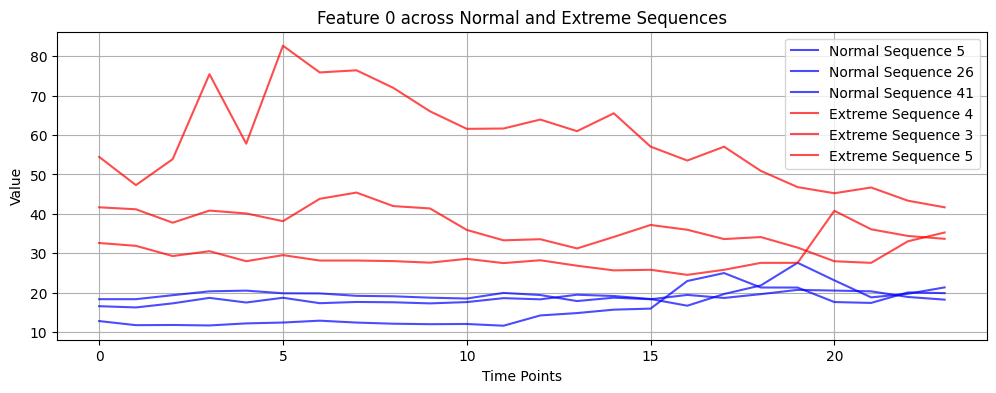

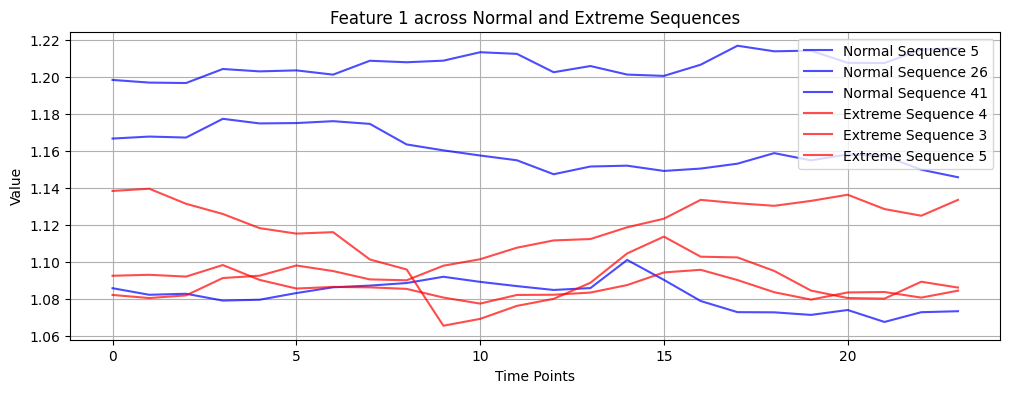

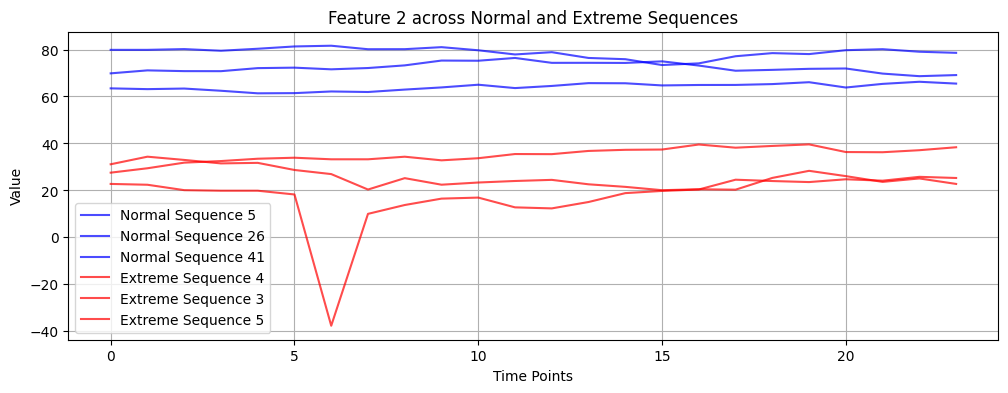

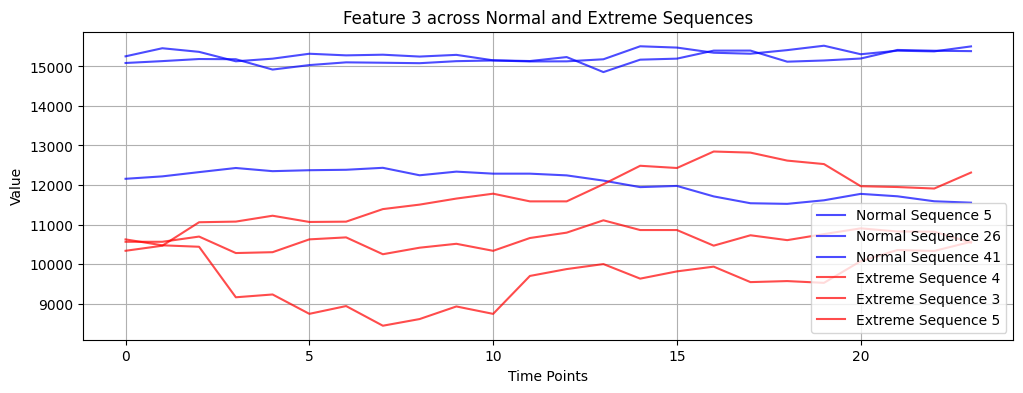

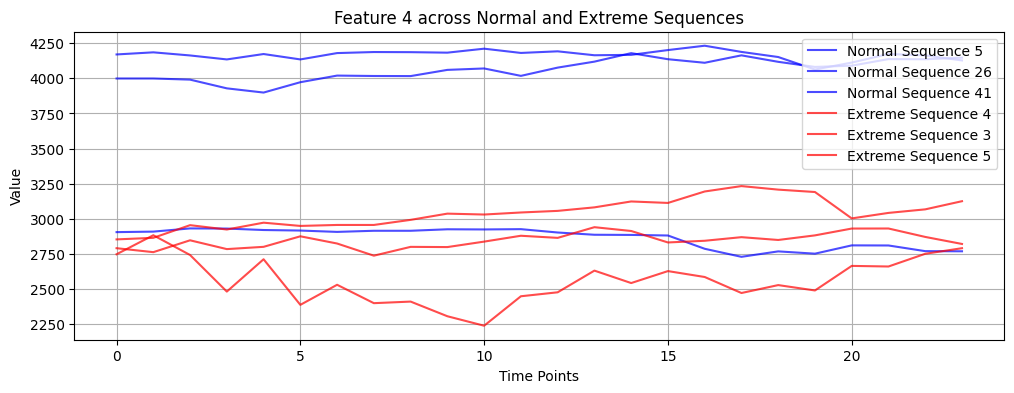

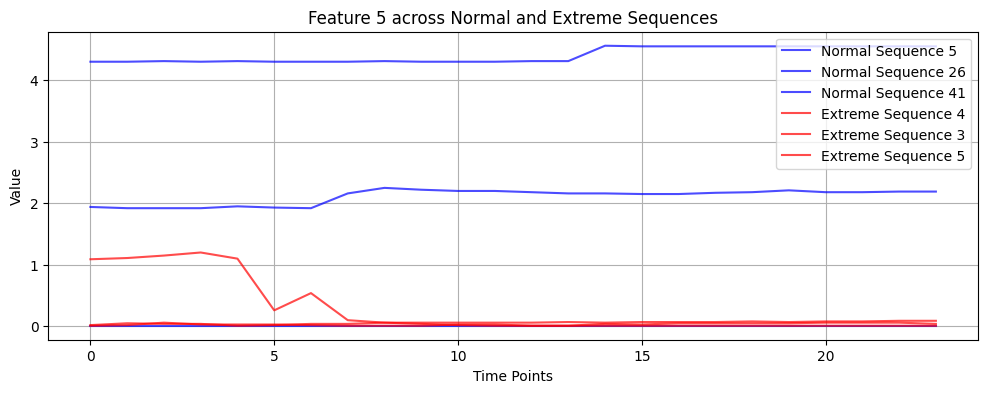

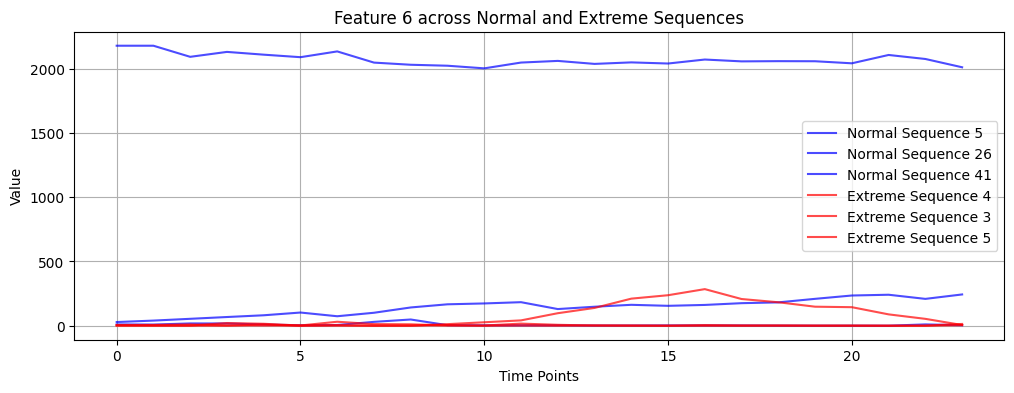

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_norm_sequences_to_plot = 3
num_ext_sequences_to_plot = 3

arr_norm = df_0
arr_ext = df_1

if len(arr_norm) > 0:
    num_features = arr_norm[0].shape[1]
elif len(arr_ext) > 0:
    num_features = arr_ext[0].shape[1]
else:
    print("Both arr_norm and arr_ext are empty. Cannot determine the number of features.")
    num_features = 0


if num_features > 0:

    # Select random sequence indices
    random_norm_indices = random.sample(range(len(arr_norm)), min(num_norm_sequences_to_plot, len(arr_norm)))
    random_ext_indices = random.sample(range(len(arr_ext)), min(num_ext_sequences_to_plot, len(arr_ext)))


    for feature_idx in range(num_features):
        plt.figure(figsize=(12, 4))


        for i in random_norm_indices:
            sequence = arr_norm[i]
            plt.plot(sequence[:, feature_idx], label=f'Normal Sequence {i+1}', color='blue', alpha=0.7)


        for i in random_ext_indices:
            sequence = arr_ext[i]
            plt.plot(sequence[:, feature_idx], label=f'Extreme Sequence {i+1}', color='red', alpha=0.7)

        plt.title(f'Feature {feature_idx} across Normal and Extreme Sequences')
        plt.xlabel('Time Points')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
fake_data = np.load('/content/drive/MyDrive/Diffusion-TS/grid_search/Macro/batch_size64_n_heads4_d_model96_timestamp200/ddpm_fake.npy')

In [ ]:

fake_data = fake_data.reshape(-1, fake_data.shape[-1])
pd.DataFrame(fake_data).describe()

,0,1,2,3,4,5,6
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.068295,0.614720,0.636116,0.381554,0.387359,0.341954,0.188751
std,0.051425,0.157032,0.064072,0.085943,0.156378,0.320448,0.249346
min,0.000000,0.103836,0.367689,0.084336,0.069253,0.000000,0.000000
25%,0.029185,0.519256,0.594750,0.314334,0.254601,0.028713,0.019063
50%,0.050742,0.583885,0.618189,0.356741,0.325911,0.288765,0.038135
75%,0.096816,0.716666,0.685388,0.448020,0.530990,0.346309,0.298129
max,0.704524,0.963679,0.928071,0.802594,0.931899,1.000000,0.926476
